# Energy prices downloaded from AEMO


[aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data](https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns
import sklearn.cluster as cluster
import time
#from pandas_profiling import ProfileReport

import statsmodels.api as sm
import statsmodels.formula.api as smf

import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import errorbar

# Specifing figure layout
%matplotlib inline
# plt.style.use('fivethirtyeight')
# sns.set_color_codes('bright')
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.rcParams["figure.figsize"] = (15, 10)

RSEED=42

## First have a look at the raw data

In [3]:
pd_nsw_12_01 = pd.read_csv('../data/aemo/price_and_demand/PRICE_AND_DEMAND_201201_NSW1.csv', 
        parse_dates=['SETTLEMENTDATE'])

In [4]:
pd_nsw_12_01.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2012-01-01 00:30:00,6976.86,24.51,TRADE
1,NSW1,2012-01-01 01:00:00,6796.47,23.05,TRADE
2,NSW1,2012-01-01 01:30:00,6494.43,22.49,TRADE
3,NSW1,2012-01-01 02:00:00,6271.40,18.02,TRADE
4,NSW1,2012-01-01 02:30:00,6107.27,17.90,TRADE


In [5]:
pd_nsw_12_01['DAY'] = pd_nsw_12_01['SETTLEMENTDATE'].dt.date

In [6]:
pd_DAY_avg = pd_nsw_12_01.groupby('DAY').mean()
pd_DAY_avg.head()

,TOTALDEMAND,RRP
DAY,,
2012-01-01,7118.604681,24.044894
2012-01-02,7560.392708,27.658333
2012-01-03,8761.376250,31.912500
2012-01-04,9035.712292,24.598542
2012-01-05,8390.441250,23.501875


<AxesSubplot:xlabel='DAY', ylabel='TOTALDEMAND'>

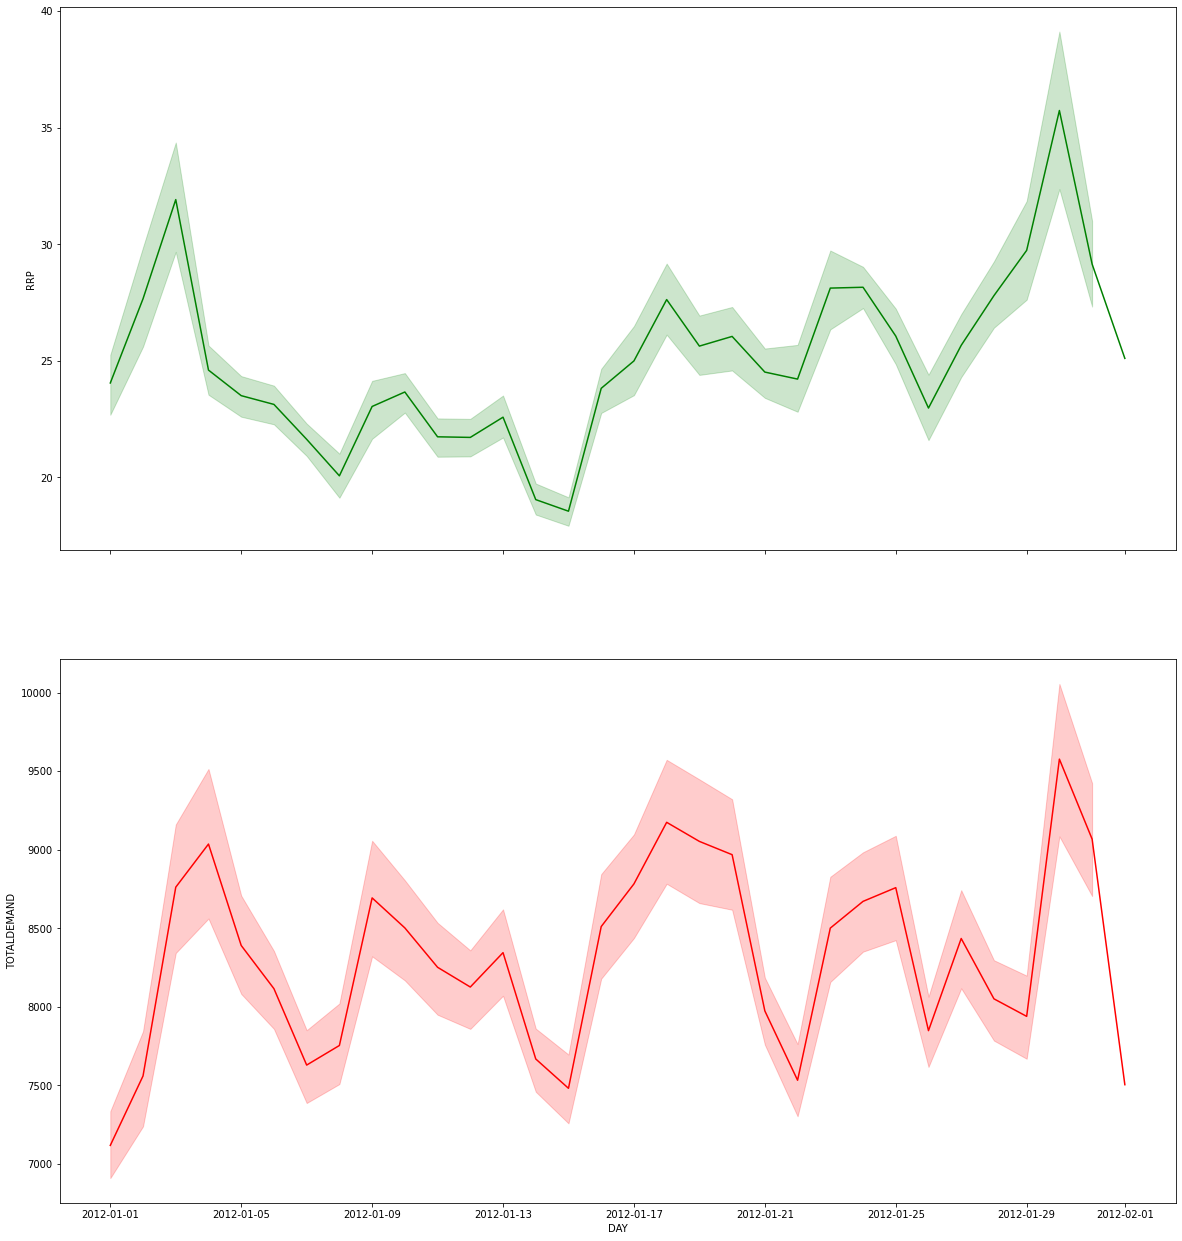

In [7]:
# Plot daily average
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()
sns.lineplot(data=pd_nsw_12_01, x='DAY', y='RRP', ax=axs[0], color='green')
sns.lineplot(data=pd_nsw_12_01, x='DAY', y='TOTALDEMAND', ax=axs[1], color='red')

<AxesSubplot:xlabel='SETTLEMENTDATE', ylabel='TOTALDEMAND'>

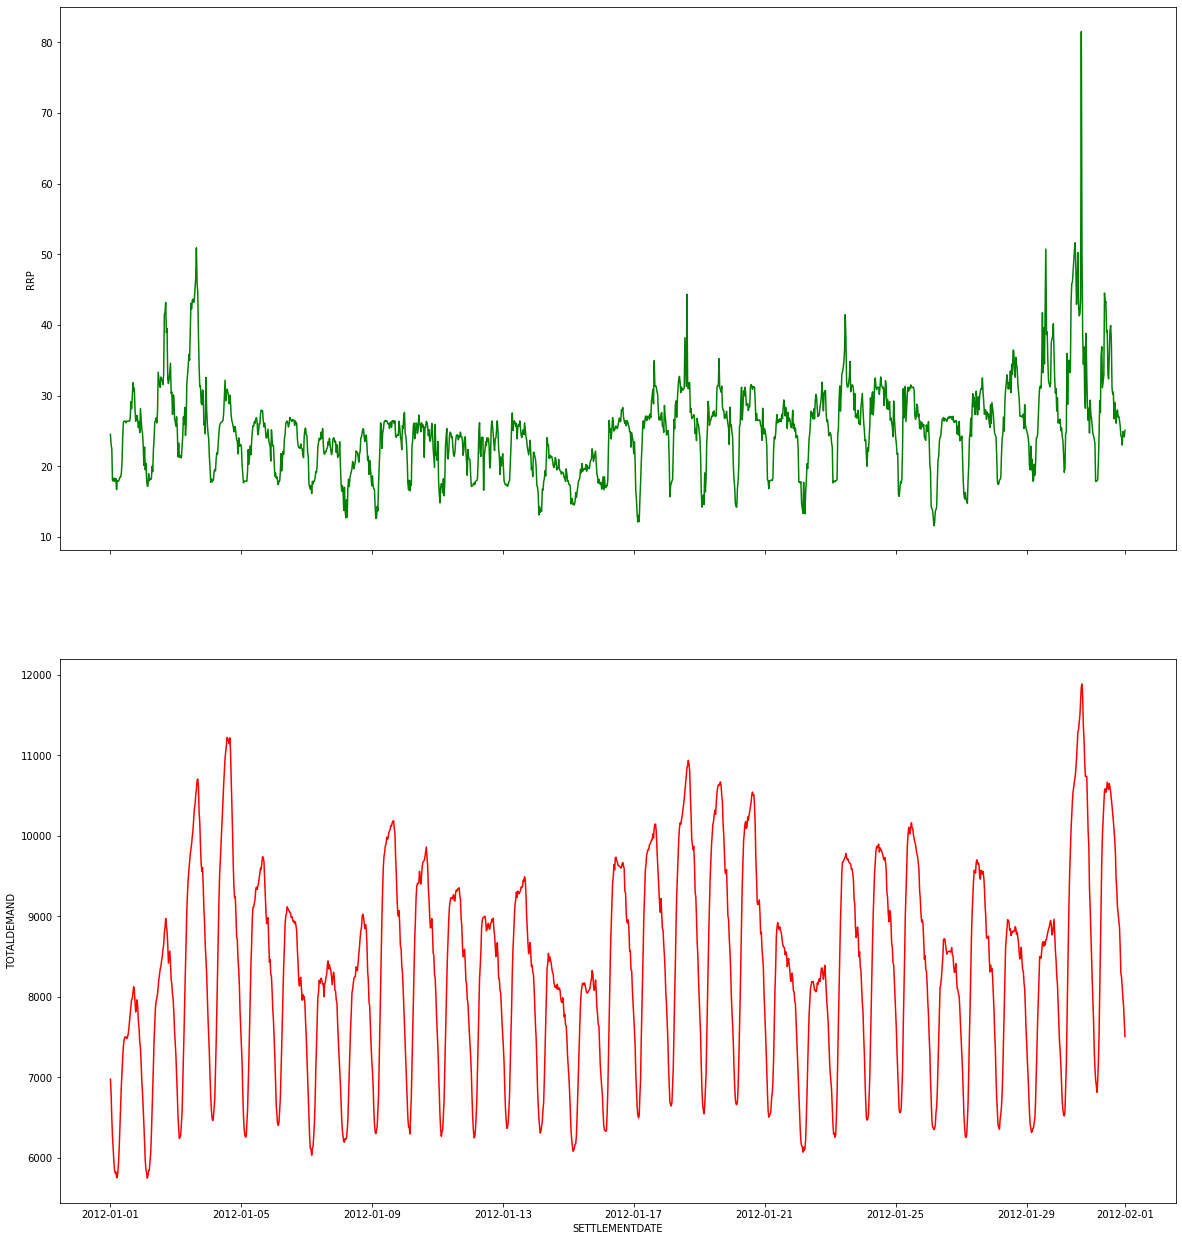

In [8]:
# Plot half-hour data
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()
sns.lineplot(data=pd_nsw_12_01, x='SETTLEMENTDATE', y='RRP', ax=axs[0], color='green')
sns.lineplot(data=pd_nsw_12_01, x='SETTLEMENTDATE', y='TOTALDEMAND', ax=axs[1], color='red')

## Load all data. Take the average of one DAY and also average over all states.

In [9]:
year = range(2012,2014)
month = range(1,13)
state = ['NSW', 'QLD', 'VIC', 'SA', 'TAS']
pc = 'PRICE_AND_DEMAND'

In [10]:
pd_all = pd.DataFrame(columns=pd_nsw_12_01.columns)
for st in state:
    for yy in year:
        for mm in month:
            pc = 'PRICE_AND_DEMAND'
            file_name = pc+'_'+str(yy)+str(mm).zfill(2)+'_'+st+'1.csv'
            tmp = pd.read_csv('../data/aemo/price_and_demand/'+file_name, 
                    parse_dates=['SETTLEMENTDATE'])
            pd_all = pd.concat([pd_all, tmp], axis=0, join='outer')
pd_all['DAY'] = pd_all['SETTLEMENTDATE'].dt.date

In [11]:
pd_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175440 entries, 0 to 1487
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          175440 non-null  object        
 1   SETTLEMENTDATE  175440 non-null  datetime64[ns]
 2   TOTALDEMAND     175440 non-null  float64       
 3   RRP             175440 non-null  float64       
 4   PERIODTYPE      175440 non-null  object        
 5   DAY             175440 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.4+ MB


In [12]:
pd_all

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,DAY
0,NSW1,2012-01-01 00:30:00,6976.86,24.51,TRADE,2012-01-01
1,NSW1,2012-01-01 01:00:00,6796.47,23.05,TRADE,2012-01-01
2,NSW1,2012-01-01 01:30:00,6494.43,22.49,TRADE,2012-01-01
3,NSW1,2012-01-01 02:00:00,6271.40,18.02,TRADE,2012-01-01
4,NSW1,2012-01-01 02:30:00,6107.27,17.90,TRADE,2012-01-01
...,...,...,...,...,...,...
1483,TAS1,2013-12-31 22:00:00,1034.41,34.32,TRADE,2013-12-31
1484,TAS1,2013-12-31 22:30:00,1005.48,34.32,TRADE,2013-12-31
1485,TAS1,2013-12-31 23:00:00,962.69,34.28,TRADE,2013-12-31
1486,TAS1,2013-12-31 23:30:00,954.62,36.29,TRADE,2013-12-31


In [13]:
pd_all

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,DAY
0,NSW1,2012-01-01 00:30:00,6976.86,24.51,TRADE,2012-01-01
1,NSW1,2012-01-01 01:00:00,6796.47,23.05,TRADE,2012-01-01
2,NSW1,2012-01-01 01:30:00,6494.43,22.49,TRADE,2012-01-01
3,NSW1,2012-01-01 02:00:00,6271.40,18.02,TRADE,2012-01-01
4,NSW1,2012-01-01 02:30:00,6107.27,17.90,TRADE,2012-01-01
...,...,...,...,...,...,...
1483,TAS1,2013-12-31 22:00:00,1034.41,34.32,TRADE,2013-12-31
1484,TAS1,2013-12-31 22:30:00,1005.48,34.32,TRADE,2013-12-31
1485,TAS1,2013-12-31 23:00:00,962.69,34.28,TRADE,2013-12-31
1486,TAS1,2013-12-31 23:30:00,954.62,36.29,TRADE,2013-12-31


In [14]:
pd_all_mean = pd_all.groupby('DAY').mean()[['TOTALDEMAND', 'RRP']]
pd_all_mean.columns = [cc+'_mean' for cc in pd_all_mean.columns]
pd_all_max = pd_all.groupby('DAY').max()[['TOTALDEMAND', 'RRP']]
pd_all_max.columns = [cc+'_max' for cc in pd_all_max.columns]
pd_all_min = pd_all.groupby('DAY').min()[['TOTALDEMAND', 'RRP']]
pd_all_min.columns = [cc+'_min' for cc in pd_all_min.columns]
pd_all_mean.head()
pd_all_daily = pd.concat([pd_all_mean, pd_all_max, pd_all_min], axis=1)

# make features
pd_all_daily = pd_all_daily.assign(RRP_ratio_max_mean = lambda x : x['RRP_max'] / x['RRP_mean'])
pd_all_daily = pd_all_daily.assign(TOTALDEMAND_ratio_max_mean = lambda x : x['TOTALDEMAND_max'] /
                                                                     x['TOTALDEMAND_mean'])
pd_all_daily = pd_all_daily.assign(RRP_ratio_min_mean = lambda x : x['RRP_min'] / x['RRP_mean'])
pd_all_daily = pd_all_daily.assign(TOTALDEMAND_ratio_min_mean = lambda x : x['TOTALDEMAND_min'] /
                                                                     x['TOTALDEMAND_mean'])

# add a rolling average
pd_all_daily[['TOTALDEMAND_mean_rolling3','RRP_mean_rolling3']] = \
                            pd_all_daily[['TOTALDEMAND_mean', 'RRP_mean']]\
                            .rolling(window=3, min_periods=1).mean()
pd_all_daily = pd_all_daily.assign(TOTALDEMAND_ratio_rolling_mean = \
                                lambda x : x['TOTALDEMAND_mean_rolling3'] / x['TOTALDEMAND_mean'])
pd_all_daily = pd_all_daily.assign(RRP_ratio_rolling_mean = \
                                lambda x : x['RRP_mean_rolling3'] / x['RRP_mean'])
# pd_all_daily.info()
# pd_all_daily.head()
ratios_price_totaldemand = pd_all_daily[['RRP_ratio_max_mean', 'RRP_ratio_min_mean', 
                                'TOTALDEMAND_ratio_max_mean', 'TOTALDEMAND_ratio_min_mean',
                                'RRP_mean_rolling3', 'TOTALDEMAND_mean_rolling3']]
ratios_price_totaldemand.head()

,RRP_ratio_max_mean,RRP_ratio_min_mean,TOTALDEMAND_ratio_max_mean,TOTALDEMAND_ratio_min_mean,RRP_mean_rolling3,TOTALDEMAND_mean_rolling3
DAY,,,,,,
2012-01-01,2.833451,0.418241,1.971340,0.198934,28.332936,4121.319021
2012-01-02,1.888420,0.483000,2.051924,0.173431,29.311406,4247.292844
2012-01-03,2.014632,0.614699,2.223403,0.184126,30.760520,4436.349549
2012-01-04,2.633071,0.598807,2.468363,0.183184,29.655014,4577.758625
2012-01-05,2.265400,0.571573,2.201436,0.224668,28.014583,4594.843750


No handles with labels found to put in legend.


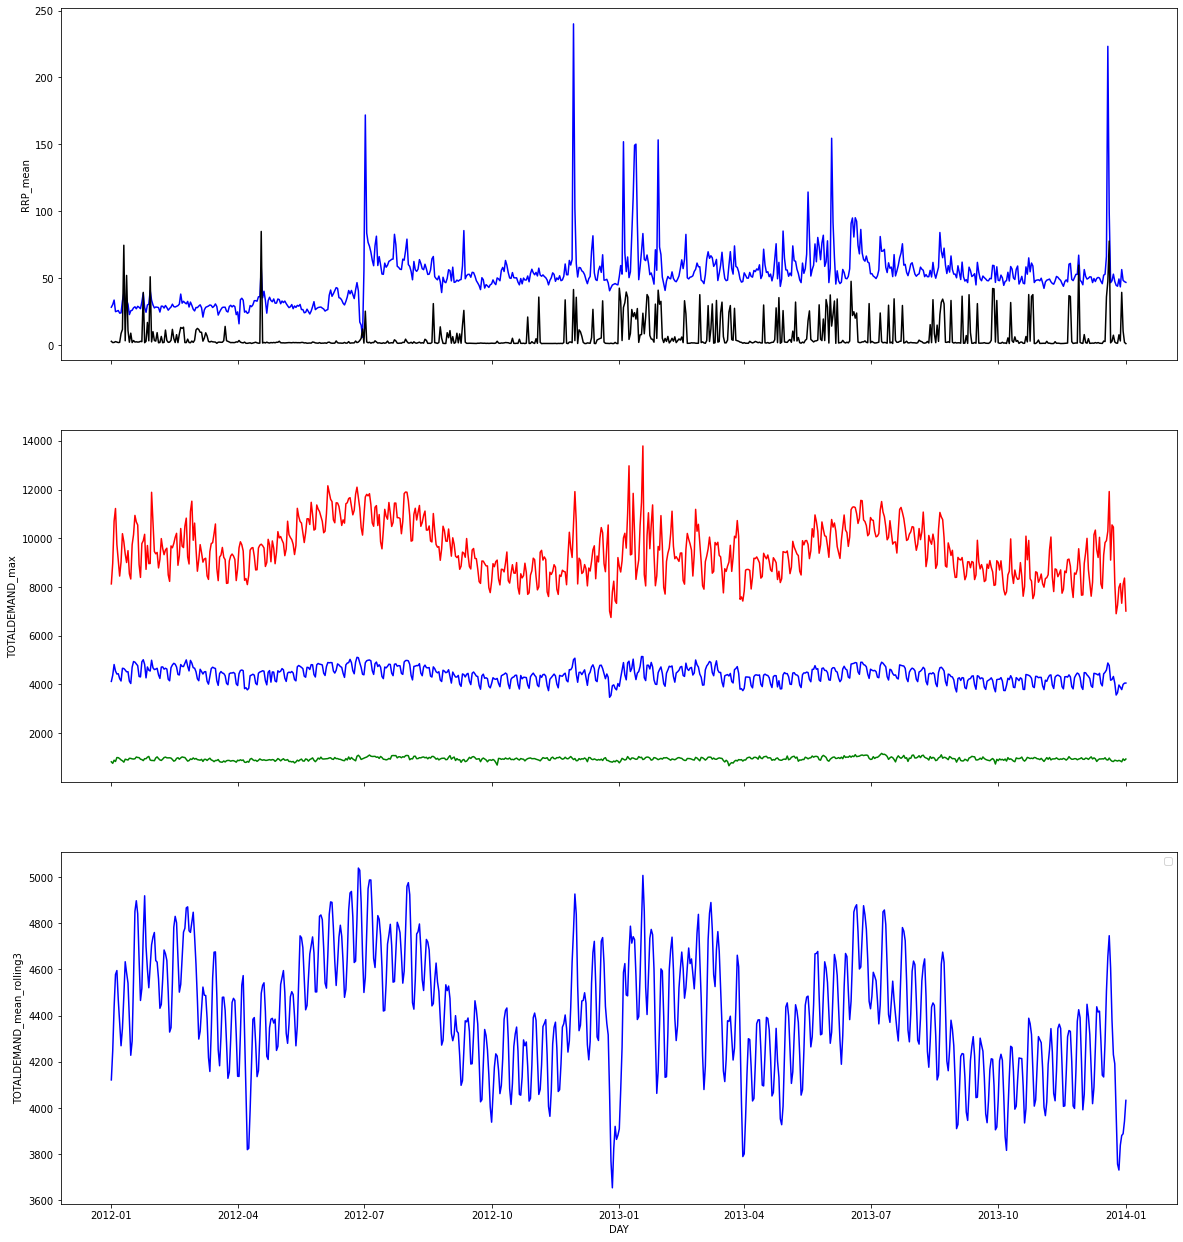

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()
#sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_max', ax=axs[0], color='red')
sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_mean', ax=axs[0], color='blue')
#sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_min', ax=axs[0], color='green')
sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_ratio_max_mean', ax=axs[0], color='black')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_max', ax=axs[1], color='red')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_mean', ax=axs[1], color='blue')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_min', ax=axs[1], color='green')
#sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_mean_rolling3', ax=axs[3], color='red')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_mean_rolling3', ax=axs[2], color='blue')
plt.legend()

In [16]:
pd_all_daily.columns
pd_all_daily = pd_all_daily[['TOTALDEMAND_mean', 'RRP_mean', 'TOTALDEMAND_max', 'RRP_max',
       'TOTALDEMAND_min', 'RRP_min', 'RRP_ratio_max_mean',
       'TOTALDEMAND_ratio_max_mean', 'RRP_ratio_min_mean',
       'TOTALDEMAND_ratio_min_mean', 'TOTALDEMAND_mean_rolling3',
       'RRP_mean_rolling3', 'TOTALDEMAND_ratio_rolling_mean',
       'RRP_ratio_rolling_mean']]

## Now use this data to predict the energy output

In [17]:
df = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
df.TARGETVAR = df.TARGETVAR.fillna(0)

In [18]:
df.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,WS10,WS100,WD10,WD100,WD100CARD,WD10CARD,U100NORM,V100NORM
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,1,3.421530,4.652334,321.614439,321.999735,NW,NW,0.615665,-0.788008
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,1,3.096451,4.154892,305.473680,306.385781,NW,NW,0.805041,-0.593219
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,1,2.795932,3.712577,287.108562,289.088098,WNW,WNW,0.945017,-0.327022
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,1,2.461699,3.234831,273.345160,276.310236,W,W,0.993941,-0.109912
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,1,2.279435,2.976332,260.159324,263.581938,W,W,0.993733,0.111782


In [19]:
df['DAY'] = df['TIMESTAMP'].dt.date

In [20]:
# Now merge the dataset and the energy prices.
# But: The energy prices have to to be shifted, since we can only use the energy prices of the day ahead

# pd_all_daily_shifted = pd_all_daily.shift(+1)

# df = df.merge(pd_all_daily_shifted[['TOTALDEMAND_mean', 'TOTALDEMAND_ratio_max_mean', 'RRP_ratio_max_mean']], on='DAY')
# df.dropna(axis=0, inplace=True)

In [21]:
#df = pd.get_dummies(df, columns=['WD100CARD'], drop_first=True)

In [51]:
target = 'TARGETVAR'
features = [feat for feat in df.columns.to_list() if not 
            (feat in [target, 'TIMESTAMP', 'WD100CARD', 'WD10CARD', 'DAY', 'U100NORM', 'V100NORM'])]

X = pd.DataFrame(df[features])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, 
            random_state=RSEED, stratify=X.ZONEID)

In [23]:
X_train.columns

Index(['ZONEID', 'U10', 'V10', 'U100', 'V100', 'HOUR', 'MONTH', 'WEEKDAY',
       'IS_HOLIDAY', 'WS10', 'WS100', 'WD10', 'WD100', 'U100NORM', 'V100NORM'],
      dtype='object')

In [24]:
zones = df.ZONEID.unique()

zone_X_train = {zone: X_train[X_train.ZONEID == zone] for zone in zones}
zone_X_test = {zone: X_test[X_test.ZONEID == zone] for zone in zones}
zone_y_train = {zone: y_train[X_train.ZONEID == zone] for zone in zones}
zone_y_test = {zone: y_test[X_test.ZONEID == zone] for zone in zones}

results = {}

y_pred_all = np.array([])
y_pred_idx = np.array([], dtype = 'int')

zone_y_train[1]

for zone in zones:
    model = LinearRegression()
    model.fit(zone_X_train[zone], zone_y_train[zone])
    y_pred = model.predict(zone_X_test[zone])
    y_pred = [1 if value > 1 else 0 if value < 0 else value for value in y_pred]
    results["ZONE" + str(zone)] = mean_squared_error(zone_y_test[zone], y_pred, squared=False)
    y_pred_all = np.concatenate([y_pred_all, y_pred], axis = 0)
    y_pred_idx = np.concatenate([y_pred_idx, zone_X_test[zone].index], axis = 0)

y_pred_all
y_pred_idx

print(mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False))

0.1762485499203732


Without energy prices:\
0.17570275736217736\
\
With energy prices of day before:\
0.1761406829192246

ZONE1 	train:	 0.16845607390400405
ZONE1 	test:	 0.17521982511177528
ZONE2 	train:	 0.1414988673829682
ZONE2 	test:	 0.14113634720295565
ZONE3 	train:	 0.14533676917032126
ZONE3 	test:	 0.15035627531294166
ZONE4 	train:	 0.16619858091905237
ZONE4 	test:	 0.1748310855145411
ZONE5 	train:	 0.1684480142347697
ZONE5 	test:	 0.17335341737326787
ZONE6 	train:	 0.17423794714124916
ZONE6 	test:	 0.17719055079068258
ZONE7 	train:	 0.12629966426519446
ZONE7 	test:	 0.12854876075330418
ZONE8 	train:	 0.1569214587976555
ZONE8 	test:	 0.16171350430302936
ZONE9 	train:	 0.15162359596596894
ZONE9 	test:	 0.15415535255836202
ZONE10 	train:	 0.19372990514947466
ZONE10 	test:	 0.19896572871859425
train:  0.1603042916547723
test:  0.16470262520638654


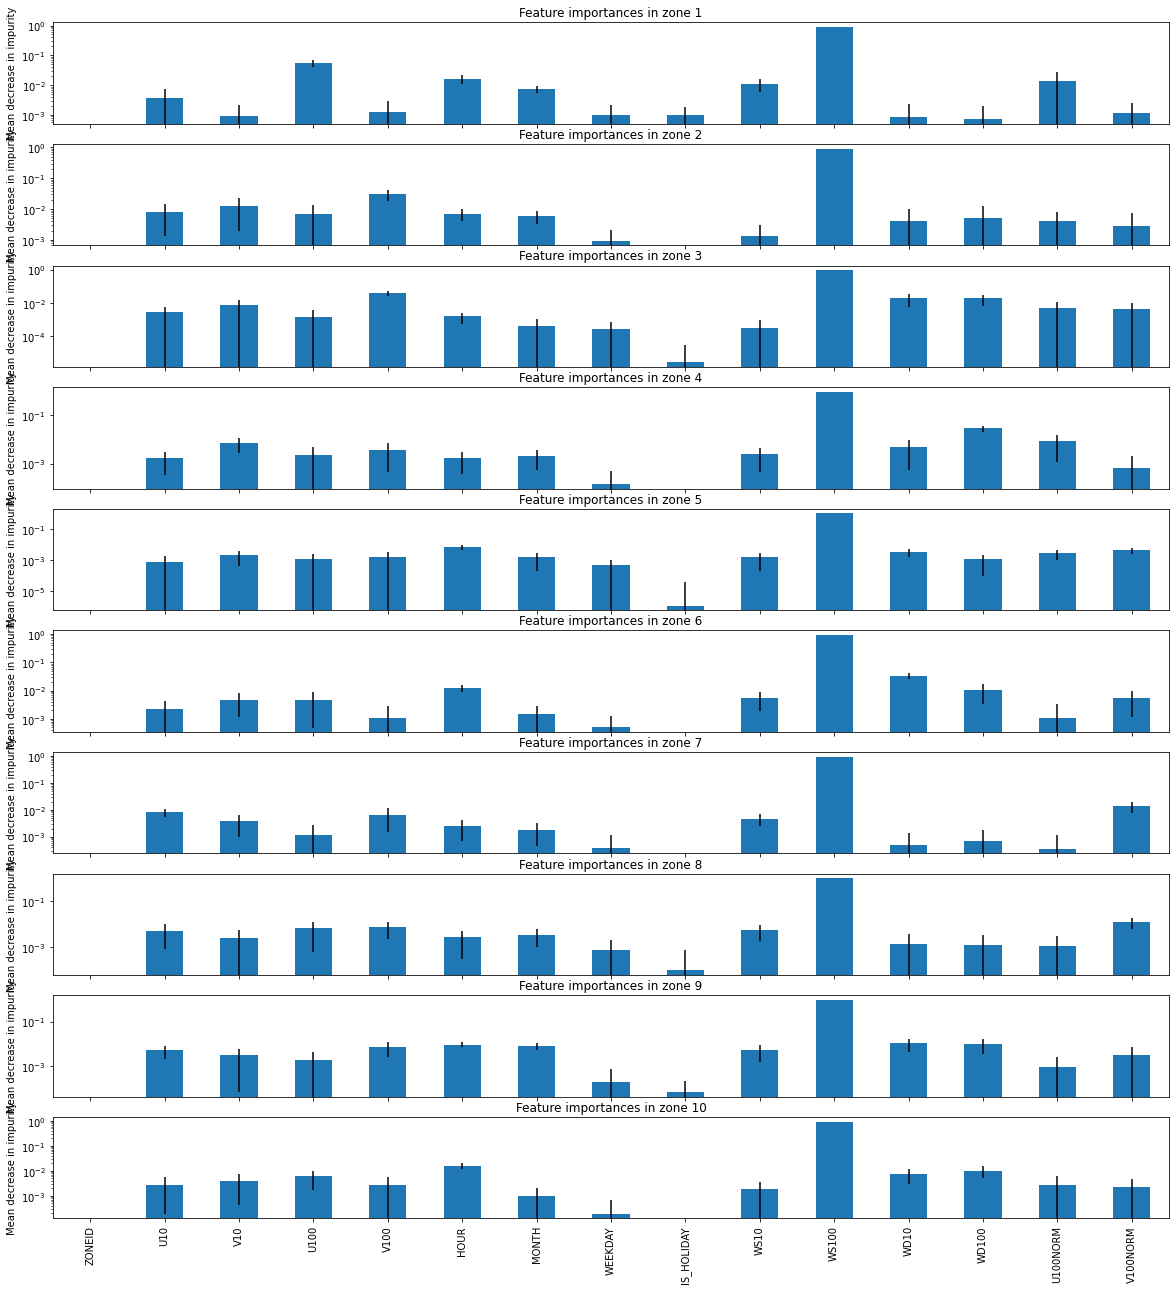

In [28]:
zones = df.ZONEID.unique()

zone_X_train = {zone: X_train[X_train.ZONEID == zone] for zone in zones}
zone_X_test = {zone: X_test[X_test.ZONEID == zone] for zone in zones}
zone_y_train = {zone: y_train[X_train.ZONEID == zone] for zone in zones}
zone_y_test = {zone: y_test[X_test.ZONEID == zone] for zone in zones}

results = {}
results_train = {}

y_pred_all = np.array([])
y_pred_idx = np.array([], dtype = 'int')
y_pred_all_train = np.array([])
y_pred_idx_train = np.array([], dtype = 'int')

fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()

from sklearn.ensemble import ExtraTreesRegressor

for zone in zones:
    model = RandomForestRegressor(n_estimators=200, max_depth=10, 
                min_samples_leaf=50, n_jobs=-1, random_state=42)
    model.fit(zone_X_train[zone], zone_y_train[zone])
    y_pred_train = model.predict(zone_X_train[zone])
    y_pred_train = [1 if value > 1 else 0 if value < 0 else value for value in y_pred_train]
    results_train["ZONE" + str(zone)] = mean_squared_error(zone_y_train[zone], y_pred_train, squared=False)
    y_pred_all_train = np.concatenate([y_pred_all_train, y_pred_train], axis = 0)
    y_pred_idx_train = np.concatenate([y_pred_idx_train, zone_X_train[zone].index], axis = 0)
    y_pred = model.predict(zone_X_test[zone])
    y_pred = [1 if value > 1 else 0 if value < 0 else value for value in y_pred]
    results["ZONE" + str(zone)] = mean_squared_error(zone_y_test[zone], y_pred, squared=False)
    y_pred_all = np.concatenate([y_pred_all, y_pred], axis = 0)
    y_pred_idx = np.concatenate([y_pred_idx, zone_X_test[zone].index], axis = 0)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=features)
    forest_importances.plot.bar(yerr=std, ax=axs[zone-1])
    axs[zone-1].set_title(f"Feature importances in zone {zone}")
    axs[zone-1].set_ylabel("Mean decrease in impurity")
    axs[zone-1].set_yscale('log')


y_pred_all
y_pred_idx

for k in results_train.keys():
    print(k,'\ttrain:\t', results_train[k])
    print(k,'\ttest:\t', results[k])

print('train: ', mean_squared_error(y_train[y_pred_idx_train], y_pred_all_train, squared=False))
print('test: ', mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False))


In [40]:
3*2*3*1*3*2 *5

540

In [47]:
n_estimators = np.linspace(start = 10, stop = 100, num = 2, dtype=int) # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = np.linspace(10, 20, num=2, dtype=int) # maximum number of levels allowed in each decision tree
min_samples_split = [10] # minimum sample number to split a node
min_samples_leaf = [1, 5, 20] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}

In [48]:
zones = df.ZONEID.unique()

zone_X_train = {zone: X_train[X_train.ZONEID == zone] for zone in zones}
zone_X_test = {zone: X_test[X_test.ZONEID == zone] for zone in zones}
zone_y_train = {zone: y_train[X_train.ZONEID == zone] for zone in zones}
zone_y_test = {zone: y_test[X_test.ZONEID == zone] for zone in zones}

results = {}
results_train = {}
hyperparams = {}

y_pred_all = np.array([])
y_pred_idx = np.array([], dtype = 'int')
y_pred_all_train = np.array([])
y_pred_idx_train = np.array([], dtype = 'int')

from sklearn.model_selection import GridSearchCV

for zone in zones:
    print(zone)
    forest = RandomForestRegressor(random_state=42)
    model = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid=random_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
    model.fit(zone_X_train[zone], zone_y_train[zone])
    hyperparams[zone] = model.best_params_
    y_pred_train = model.predict(zone_X_train[zone])
    y_pred_train = [1 if value > 1 else 0 if value < 0 else value for value in y_pred_train]
    results_train["ZONE" + str(zone)] = mean_squared_error(zone_y_train[zone], y_pred_train, squared=False)
    y_pred_all_train = np.concatenate([y_pred_all_train, y_pred_train], axis = 0)
    y_pred_idx_train = np.concatenate([y_pred_idx_train, zone_X_train[zone].index], axis = 0)
    y_pred = model.predict(zone_X_test[zone])
    y_pred = [1 if value > 1 else 0 if value < 0 else value for value in y_pred]
    results["ZONE" + str(zone)] = mean_squared_error(zone_y_test[zone], y_pred, squared=False)
    y_pred_all = np.concatenate([y_pred_all, y_pred], axis = 0)
    y_pred_idx = np.concatenate([y_pred_idx, zone_X_test[zone].index], axis = 0)


y_pred_all
y_pred_idx

for k in results_train.keys():
    print(k,'\ttrain:\t', results_train[k])
    print(k,'\ttest:\t', results[k])

print('train: ', mean_squared_error(y_train[y_pred_idx_train], y_pred_all_train, squared=False))
print('test: ', mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False))


1
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/fklein/neuefische/capstone/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/fklein/neuefische/capstone/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/fklein/neuefische/capstone/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/fklein/neuefische/capstone/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_feat

In [50]:
hyperparams

{1: {'bootstrap': False,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 100},
 2: {'bootstrap': False,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 100},
 3: {'bootstrap': False,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 100},
 4: {'bootstrap': False,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 100},
 5: {'bootstrap': False,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 100},
 6: {'bootstrap': True,
  'max_depth': 20,
  'max_features': 'auto',
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 100},
 7: {'bootstrap': False,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  '

In [49]:
for k in results_train.keys():
    print(k,'\ttrain:\t', results_train[k])
    print(k,'\ttest:\t', results[k])

print('train: ', mean_squared_error(y_train[y_pred_idx_train], y_pred_all_train, squared=False))
print('test: ', mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False))

ZONE1 	train:	 0.06225924512137477
ZONE1 	test:	 0.1549213507532067
ZONE2 	train:	 0.052310714678182255
ZONE2 	test:	 0.1272613204696215
ZONE3 	train:	 0.053201638765338906
ZONE3 	test:	 0.13741061472728738
ZONE4 	train:	 0.09318667839295583
ZONE4 	test:	 0.1613516619329987
ZONE5 	train:	 0.06326920267819587
ZONE5 	test:	 0.15826439014821145
ZONE6 	train:	 0.1114750428169601
ZONE6 	test:	 0.1628149891430451
ZONE7 	train:	 0.046097048628217896
ZONE7 	test:	 0.11476029329967917
ZONE8 	train:	 0.057784929985291604
ZONE8 	test:	 0.1452232411590457
ZONE9 	train:	 0.05729100430831233
ZONE9 	test:	 0.14151665754505457
ZONE10 	train:	 0.07242559605697663
ZONE10 	test:	 0.18171711046153607
train:  0.06967656364483962
test:  0.1496583541343275


Without energy prices:\
0.1523201586159654\
\
With energy prices of day before:\
0.142563257342934

---

With dummies:\
test:  0.15265109046143172\
test:  0.15320851941181576

## Investigating how much difference it makes to drop certain features

In [ ]:
def fit_predict_by_zone(regr, X_train, X_test, y_train, y_test):
    '''
    Fit the regressor regr to X_train by zone and predict the X_test.
    Returns the rmse for the whole data set.
    '''
    zones = X_train.ZONEID.unique()

    zone_X_train = {zone: X_train[X_train.ZONEID == zone] for zone in zones}
    zone_X_test = {zone: X_test[X_test.ZONEID == zone] for zone in zones}
    zone_y_train = {zone: y_train[X_train.ZONEID == zone] for zone in zones}
    zone_y_test = {zone: y_test[X_test.ZONEID == zone] for zone in zones}

    results = {}
    results_train = {}

    y_pred_all = np.array([])
    y_pred_idx = np.array([], dtype = 'int')
    y_pred_all_train = np.array([])
    y_pred_idx_train = np.array([], dtype = 'int')

    fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
    axs = axs.ravel()


    for zone in zones:
        model = regr
        model.fit(zone_X_train[zone], zone_y_train[zone])
        y_pred_train = model.predict(zone_X_train[zone])
        y_pred_train = [1 if value > 1 else 0 if value < 0 else value for value in y_pred_train]
        results_train["ZONE" + str(zone)] = mean_squared_error(zone_y_train[zone], y_pred_train, squared=False)

        results_train["ZONE" + str(zone)] = predict_X(model, zone_X_test[zone], zone_y_train[zone])
        y_pred_all_train = np.concatenate([y_pred_all_train, y_pred_train], axis = 0)
        y_pred_idx_train = np.concatenate([y_pred_idx_train, zone_X_train[zone].index], axis = 0)
        results["ZONE" + str(zone)] = predict_X(model, zone_X_test[zone], zone_y_train[zone])
        y_pred_all = np.concatenate([y_pred_all, y_pred], axis = 0)
        y_pred_idx = np.concatenate([y_pred_idx, zone_X_test[zone].index], axis = 0)
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        forest_importances = pd.Series(importances, index=features)
        forest_importances.plot.bar(yerr=std, ax=axs[zone-1])
        axs[zone-1].set_title(f"Feature importances in zone {zone}")
        axs[zone-1].set_ylabel("Mean decrease in impurity")
        axs[zone-1].set_yscale('log')

    for k in results_train.keys():
        print(k,'\ttrain:\t', results_train[k])
        print(k,'\ttest:\t', results[k])

    rmse_train = mean_squared_error(y_train[y_pred_idx_train], y_pred_all_train, squared=False)
    rmse_test = mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False)

    print('train: ', rmse_train)
    print('test: ', rmse_test)

    return rmse_train, rmse_test

def predict_X(model, X, y_val):
    '''
    Takes a fitted model and predicts y given X. 
    Returns the rmse with y_val.
    '''
    y_pred_ = model.predict(X)
    y_pred = [1 if value > 1 else 0 if value < 0 else value for value in y_pred]
    return mean_squared_error(y_val, y_pred, squared=False)